# Exercise 1: <br> Calibrate the Cepheid P-L relation in the Milky Way with Gaia 

In this exercise, we will use the sample of Milky Way Cepheids with apparent magnitudes measured with HST by Riess et al. (2021) (https://ui.adsabs.harvard.edu/abs/2021ApJ...908L...6R/abstract). The Gaia mission measures the parallax of each Cepheid, which can be approximated to the inverse of the distance. Thanks to their known distance (or parallax), we can infer the absolute magnitude of these Cepheids and therefore calibrate the Period-Luminosity Relation (hereafter the P-L relation). Once calibrated, this relation will be used to measure the distance to other galaxies (see Notebook 2). 

First we import packages:

In [33]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import astropy.units as u
from uncertainties import unumpy as unp
from uncertainties import ufloat

Type here the path where you placed the notebook and data files:

In [34]:
path_data = '/Users/louise/Desktop/2025-04-24_CosmoVerse_Lecture_Cepheids/Tutorials/'

Here, we read the data file from Riess+2021. Columns are: <br> 
- Cepheid name, <br> 
- log(period), <br> 
- apparent magnitudes in HST filters F555W, F814W, F160W and respective errors, <br> 
- "mHW" Wesenheit magnitdue (see definition below) and error, <br> 
- metallicity (Fe/H), <br> 
- "plx_exp" expected parallax and error, <br> 
- "plx_EDR3" Gaia DR3 parallax and error.  

In [35]:
R21 = pd.read_csv(path_data + 'Riess2021_tab1.dat', sep='\s+', header=0) 
print(R21)

      Cepheid   logP    F555W  eF555W  F814W  eF814W  F160W  eF160W    mHW  \
0      AA-GEM  1.053   9.9130   0.029  8.542   0.025  7.348   0.017  6.860   
1      AD-PUP  1.133  10.0150   0.028  8.675   0.023  7.488   0.020  7.011   
2      AQ-CAR  0.990   8.9836   0.020  7.854   0.009  6.766   0.007  6.373   
3      AQ-PUP  1.479   8.8671   0.018  7.120   0.014  5.487   0.013  4.859   
4      BK-AUR  0.903   9.5609   0.036  8.220   0.038  7.015   0.021  6.539   
..        ...    ...      ...     ...    ...     ...    ...     ...    ...   
59      V-VEL  0.641   7.5198   0.013  6.555   0.010  5.693   0.027  5.366   
60  V0386-CYG  0.721   9.8126   0.015  7.748   0.014  5.944   0.027  5.192   
61  V0482-SCO  0.656   8.0697   0.013  6.773   0.013  5.697   0.027  5.242   
62  V0636-SCO  0.832   6.8167   0.009  5.618   0.008  4.568   0.020  4.154   
63      W-GEM  0.898   7.0841   0.057  5.899   0.018  4.863   0.027  4.454   

    e_mHW   Fe/H  plx_exp  e_plx_exp  plx_DR3  e_plx_DR3  
0   

<b> Note: </b> <br> In this exercise we calibrate the Cepheid Period-Luminosity relation in the HST near-infrared filter F160W, which is similar to the H-band filter. Although this filter is very little affected by dust (compared to optical filters), F160W apparent magnitudes still need to be corrected for interstellar extinction. Therefore, we adopt a corrected F160W magnitude called the "Wesenheit" index (mHW), defined as: <br> 

<b> mHW = F160W - 0.386 * (F555W - F814W) </b> <br> 

where we subtract a color term to F160W apparent magnitudes. These are provided in the column "mHW" of the data table. <br> 

We now define a list of logP, apparent magnitudes "app_mag" with their errors, and Gaia DR3 parallaxes with their errors for this Cepheid sample.

In [27]:
logP = list(R21['logP'])
app_mag,  e_app_mag  = list(R21['mHW']),     list(R21['e_mHW'])
parallax, e_parallax = list(R21['plx_DR3']), list(R21['e_plx_DR3'])

Gaia DR3 parallaxes cannot be used directly and must account for some small corrections. Parallaxes provided in the data table already include the parallax offset correction as derived in Lindegren et al. (2021) (https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...4L/abstract). This small correction depends on the brightness, color and position of each source. In addition, for bright stars like Cepheids, a 0.014 mas uniform corrective term must be subtracted to each parallax (see Riess et al. 2021).

In [36]:
parallax_corr = [x-0.014 for x in parallax]

The absolute magnitude "M" of a Cepheid can be derived from its apparent magnitude "mHW" (in mag) and its parallax "plx" (in milli arcsec, as given in the data table): <br> 

<b> M = mHW + 5*log(plx) - 10  </b> <br>

We propagate the errors from apparent magnitudes and from parallaxes into the absolute magnitude error:

In [37]:
abs_mag_with_uncert = [ufloat(app_mag[i], e_app_mag[i]) + 5*unp.log10(ufloat(parallax_corr[i], e_parallax[i])) -10 for i in range(len(R21))]

abs_mag   = [M.nominal_value for M in abs_mag_with_uncert]
e_abs_mag = [M.std_dev       for M in abs_mag_with_uncert]

We can now plot the absolute magnitude vs the logP for each Cepheid and see if they verify a Period-Luminosity relation:

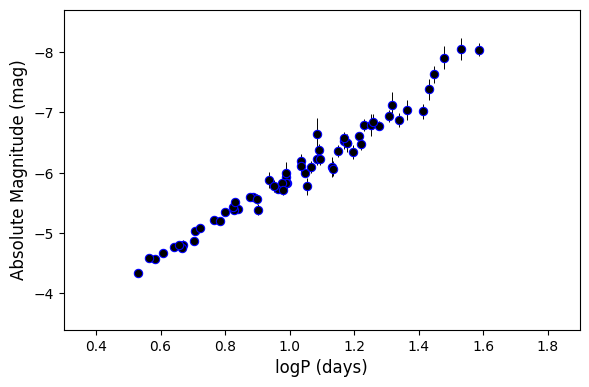

In [39]:
plt.figure(figsize=(6,4))
plt.subplots_adjust(left=0.10, right=0.96, top=0.92, bottom=0.12, hspace=0.1, wspace=0.3)

plt.errorbar(logP, abs_mag, yerr=e_abs_mag, fmt='o', color='blue', markerfacecolor='k', 
             markeredgewidth=0.8, markersize=6, capsize=0, ecolor='k', elinewidth=0.7)

plt.xlim(0.3, 1.9)
plt.ylim(-8.7, -3.4)
plt.gca().invert_yaxis()
plt.xlabel('logP (days)', fontsize=12)
plt.ylabel('Absolute Magnitude (mag)', fontsize=12)
plt.show()

We fit the Period-Luminosity relation with a simple linear equation: <b> M = a*logP + b</b>

In [31]:
popt, pcov = curve_fit(lambda X, A, B: A*X+B, logP, abs_mag, sigma=e_abs_mag)
slope, intercept = popt[0], popt[1]
e_slope, e_intercept = np.sqrt(np.diag(pcov))[0], np.sqrt(np.diag(pcov))[1]

print(f' -> M = ({slope:.2f} ± {e_slope:.2f})*logP  - ({-intercept:.2f} ± {e_intercept:.2f}) ')

 -> M = (-3.28 ± 0.05)*logP  - (2.65 ± 0.04) 


<b> This relation is the absolute calibration of the Period-Luminosity relation in the Milky Way. </b>

We plot the PL relation again, now with the fit:

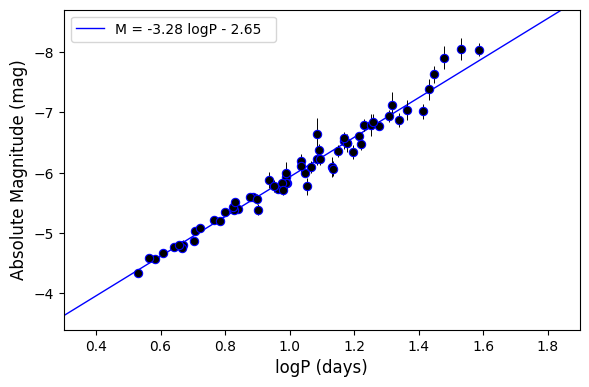

In [ ]:
xfine = np.linspace(0.2, 2.4, 100) 

plt.figure(figsize=(6,4))
plt.subplots_adjust(left=0.10, right=0.96, top=0.92, bottom=0.12, hspace=0.1, wspace=0.3)

plt.plot(xfine, slope*xfine + intercept, '-b', linewidth=1, label=f'M = {slope:.2f} logP - {-intercept:.2f}  ')
plt.errorbar(logP, abs_mag, yerr=e_abs_mag, fmt='o', color='blue', markerfacecolor='k', 
             markeredgewidth=0.8, markersize=6, capsize=0, ecolor='k', elinewidth=0.7)

plt.xlim(0.3, 1.9)
plt.ylim(-8.7, -3.4)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('logP (days)', fontsize=12)
plt.ylabel('Absolute Magnitude (mag)', fontsize=12)
plt.show()

To measure the distance to a Cepheid using the absolute Period-Luminosity relation, one should measure the Cepheid pulsation period P and its apparent magnitude mHW in the same filter as the absolute calibration. The Period-Luminosity relation is used to estimate the absolute magnitude of the Cepheid. Then, the comparison between absolute and apparent magnitude gives the distance: 

<b> M = mHW - 5*log d (kpc) - 10  </b> <br>
